In [214]:
import pandas as pd
import numpy as np
import pytz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from bumpplot import bumpchart
from statsmodels.nonparametric.smoothers_lowess import lowess
import itertools
pd.set_option('display.max_columns', None)

In [215]:
# reading the tables
solar_actual_2018_5min = pd.read_csv('solar_actual_2018_5min.csv',parse_dates=['Time'])
solar_actual_2018_5min = solar_actual_2018_5min.reindex(sorted(solar_actual_2018_5min.columns), axis=1)
solar_day_ahead_forecast_2018 = pd.read_csv('solar_day_ahead_forecast_2018.csv',parse_dates=['horizon_time','issue_time'])
solar_day_ahead_forecast_2018 = solar_day_ahead_forecast_2018.reindex(sorted(solar_day_ahead_forecast_2018.columns), axis=1)
solar_meta = pd.read_csv('solar_meta_new.csv')

texa_time = pytz.timezone('Etc/GMT-5')
solar_day_ahead_forecast_2018['horizon_time'] = solar_day_ahead_forecast_2018['horizon_time'].dt.tz_localize('ETC/GMT-4')
solar_day_ahead_forecast_2018['horizon_time'] = solar_day_ahead_forecast_2018['horizon_time'].dt.tz_convert('ETC/GMT+3')
solar_actual_2018_5min['Time'] = solar_actual_2018_5min['Time'].dt.tz_localize('ETC/GMT+3')
#solar_actual_2018_5min['Time'] = solar_actual_2018_5min['Time'].dt.tz_convert('ETC/GMT+0')


solar_day_ahead_forecast_2018 = solar_day_ahead_forecast_2018.drop(columns = ['issue_time', 'Unnamed: 0'])

solar_actual_2018_5min.drop('solar109',axis = 1, inplace = True)
solar_actual_2018_5min.drop('Zier Solar',axis = 1, inplace = True)
solar_actual_2018_5min.drop('Misae Solar',axis = 1, inplace = True)
solar_day_ahead_forecast_2018.drop('solar109',axis = 1, inplace = True)
solar_day_ahead_forecast_2018.drop('Zier Solar',axis = 1, inplace = True)
solar_day_ahead_forecast_2018.drop('Misae Solar',axis = 1, inplace = True)
solar_meta = solar_meta[~solar_meta.site_ids.str.contains('solar109')]
solar_meta = solar_meta[~solar_meta.site_ids.str.contains('Zier Solar')]
solar_meta = solar_meta[solar_meta.site_ids != 'Misae Solar']

marker_dict = {'NORTH CENTRAL':"^", 'NORTH':"x", 'WEST':"+", 'FAR WEST':"o", 'SOUTHERN':"s", 'SOUTH CENTRAL':"*",'COAST':'.','EAST':'P'}


In [216]:
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Solar hours')

In [217]:
solar_actual = solar_actual_2018_5min
solar_actual = solar_actual[solar_actual['Time'].dt.minute == 0]
solar_forcast = solar_day_ahead_forecast_2018
solar_actual = solar_actual.reset_index()
solar_forcast = solar_forcast.reset_index()
bias = solar_actual.copy(deep=True)

for col in solar_actual.columns:
    if col != 'Time':
        bias[col] = solar_actual[col] - solar_forcast[col]
bias.drop('Time',axis = 1, inplace = True)
bias.drop('index',axis = 1, inplace = True)

for (farm, data) in bias.iteritems():
    capacity = solar_meta.loc[solar_meta['site_ids']==farm]['AC_capacity_MW']
    bias[farm] = bias[farm].div(capacity.values[0])
bias = bias.reindex(sorted(bias.columns,key=str.lower), axis=1)
bias.to_csv('bias.csv')

In [218]:
all = []
for col in bias.columns:
    if col != 'index':
        isolated = np.array([ list(x[1]) for x in itertools.groupby(bias[col], lambda x: x == 0) if not x[0] ])
        
        # std of the bias
        summation = [np.std(x) for x in itertools.zip_longest(*isolated, fillvalue=0)]
        all += [summation]

data = []
for i in range(0,15):

    subdata = []
    for col in all:
        if i < len(col):
            subdata += [col[i]]
        else:
            subdata += [0]
    data += [subdata]
len(data)


/var/folders/cg/4dvsxst920bcby29c1jgnx280000gn/T/ipykernel_32865/3912915216.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  isolated = np.array([ list(x[1]) for x in itertools.groupby(bias[col], lambda x: x == 0) if not x[0] ])


15

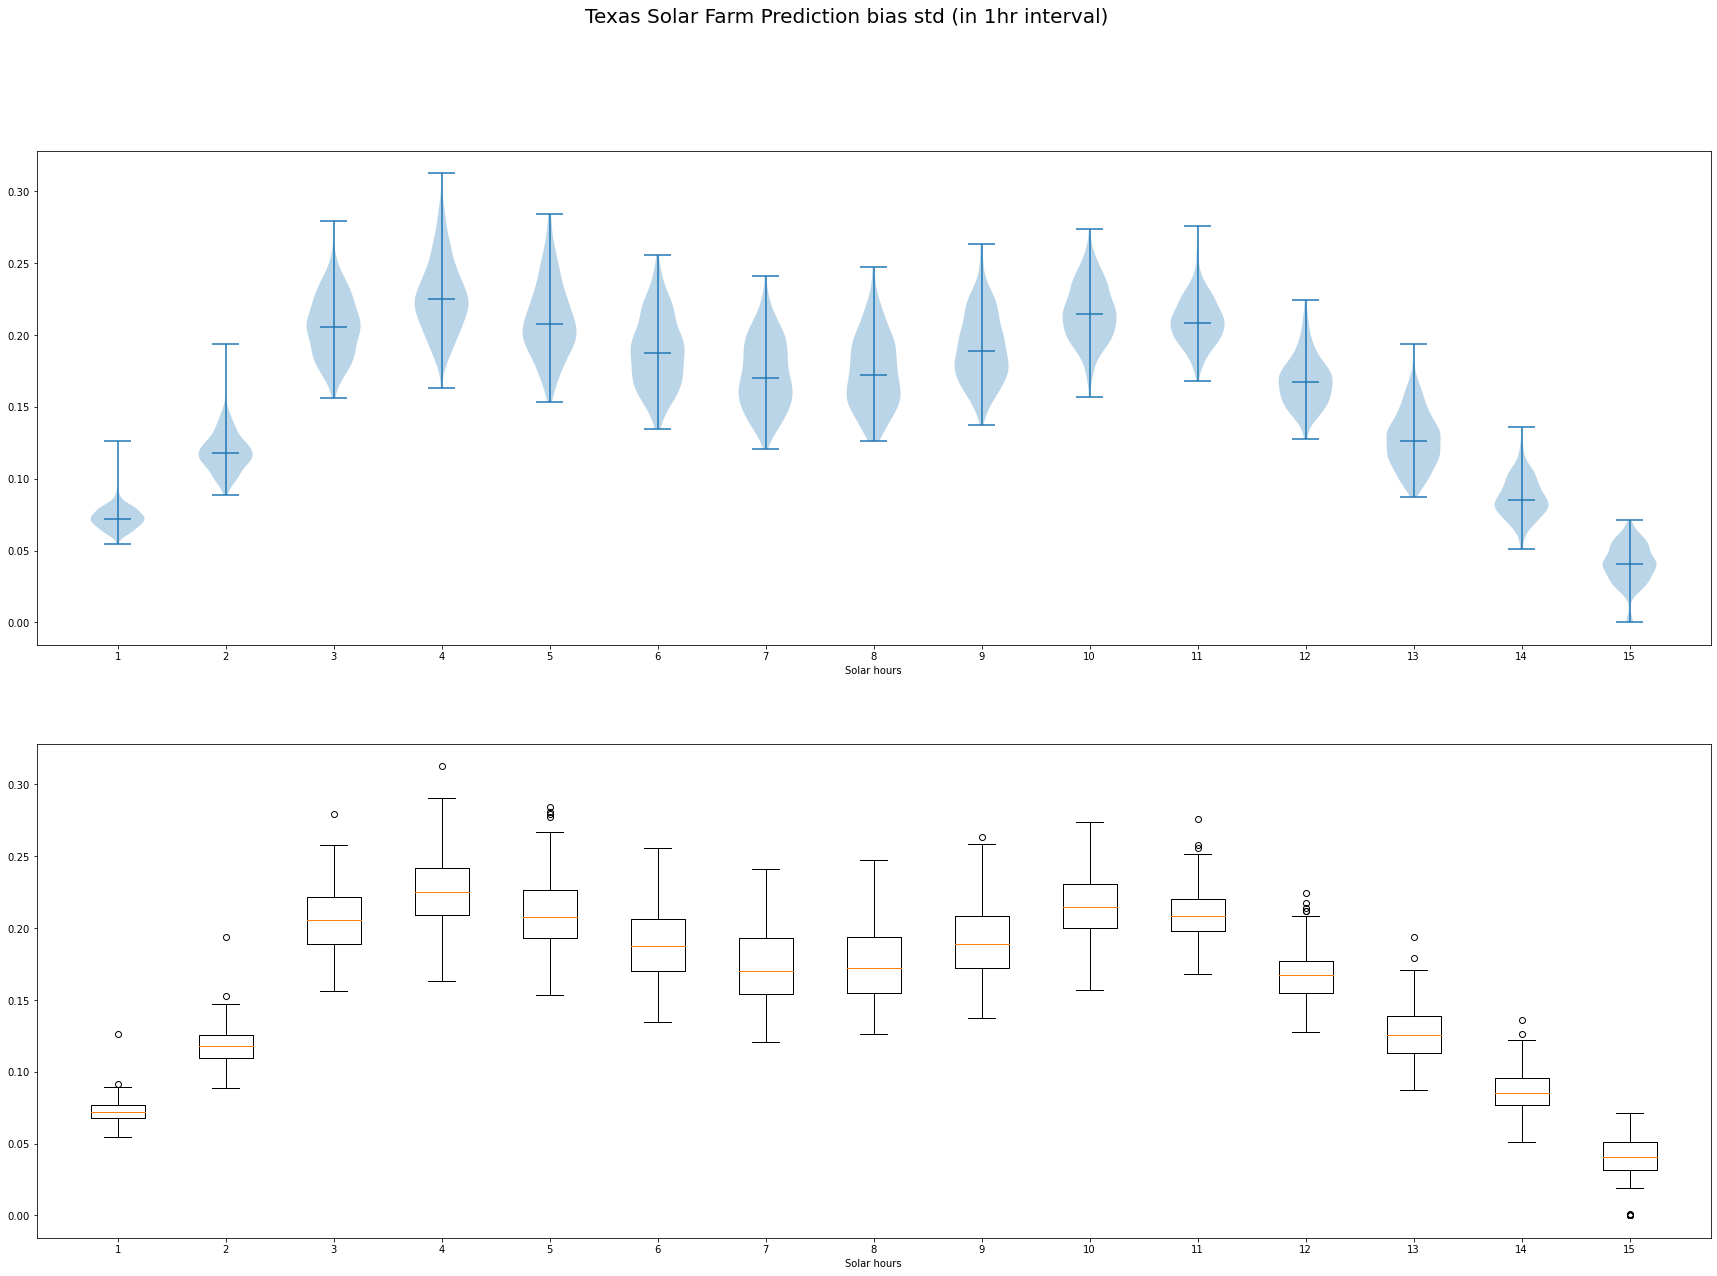

In [219]:
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(30,20))
labels = []

labels = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15"]
axs[0].violinplot(data,showmedians=True)
axs[1].boxplot(data)
set_axis_style(axs[1], labels)
set_axis_style(axs[0], labels)
fig.suptitle("Texas Solar Farm Prediction bias std (in 1hr interval)", fontsize=20)
plt.savefig('plots/violin_and_box_std_of_bias_1hr.png')
plt.show()

In [220]:
all = []
for col in bias.columns:
    if col != 'index':
        isolated = np.array([ list(x[1]) for x in itertools.groupby(bias[col], lambda x: x == 0) if not x[0] ])
        summation = [np.sum(x) for x in itertools.zip_longest(*isolated, fillvalue=0)]
        summation = [x/365 for x in summation]
        
        all += [summation]

data = []
for i in range(0,15):
    subdata = []
    for col in all:
        if i < len(col):
            subdata += [col[i]]
        else:
            subdata += [0]
    data += [subdata]
len(data)

/var/folders/cg/4dvsxst920bcby29c1jgnx280000gn/T/ipykernel_32865/3465076052.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  isolated = np.array([ list(x[1]) for x in itertools.groupby(bias[col], lambda x: x == 0) if not x[0] ])


15

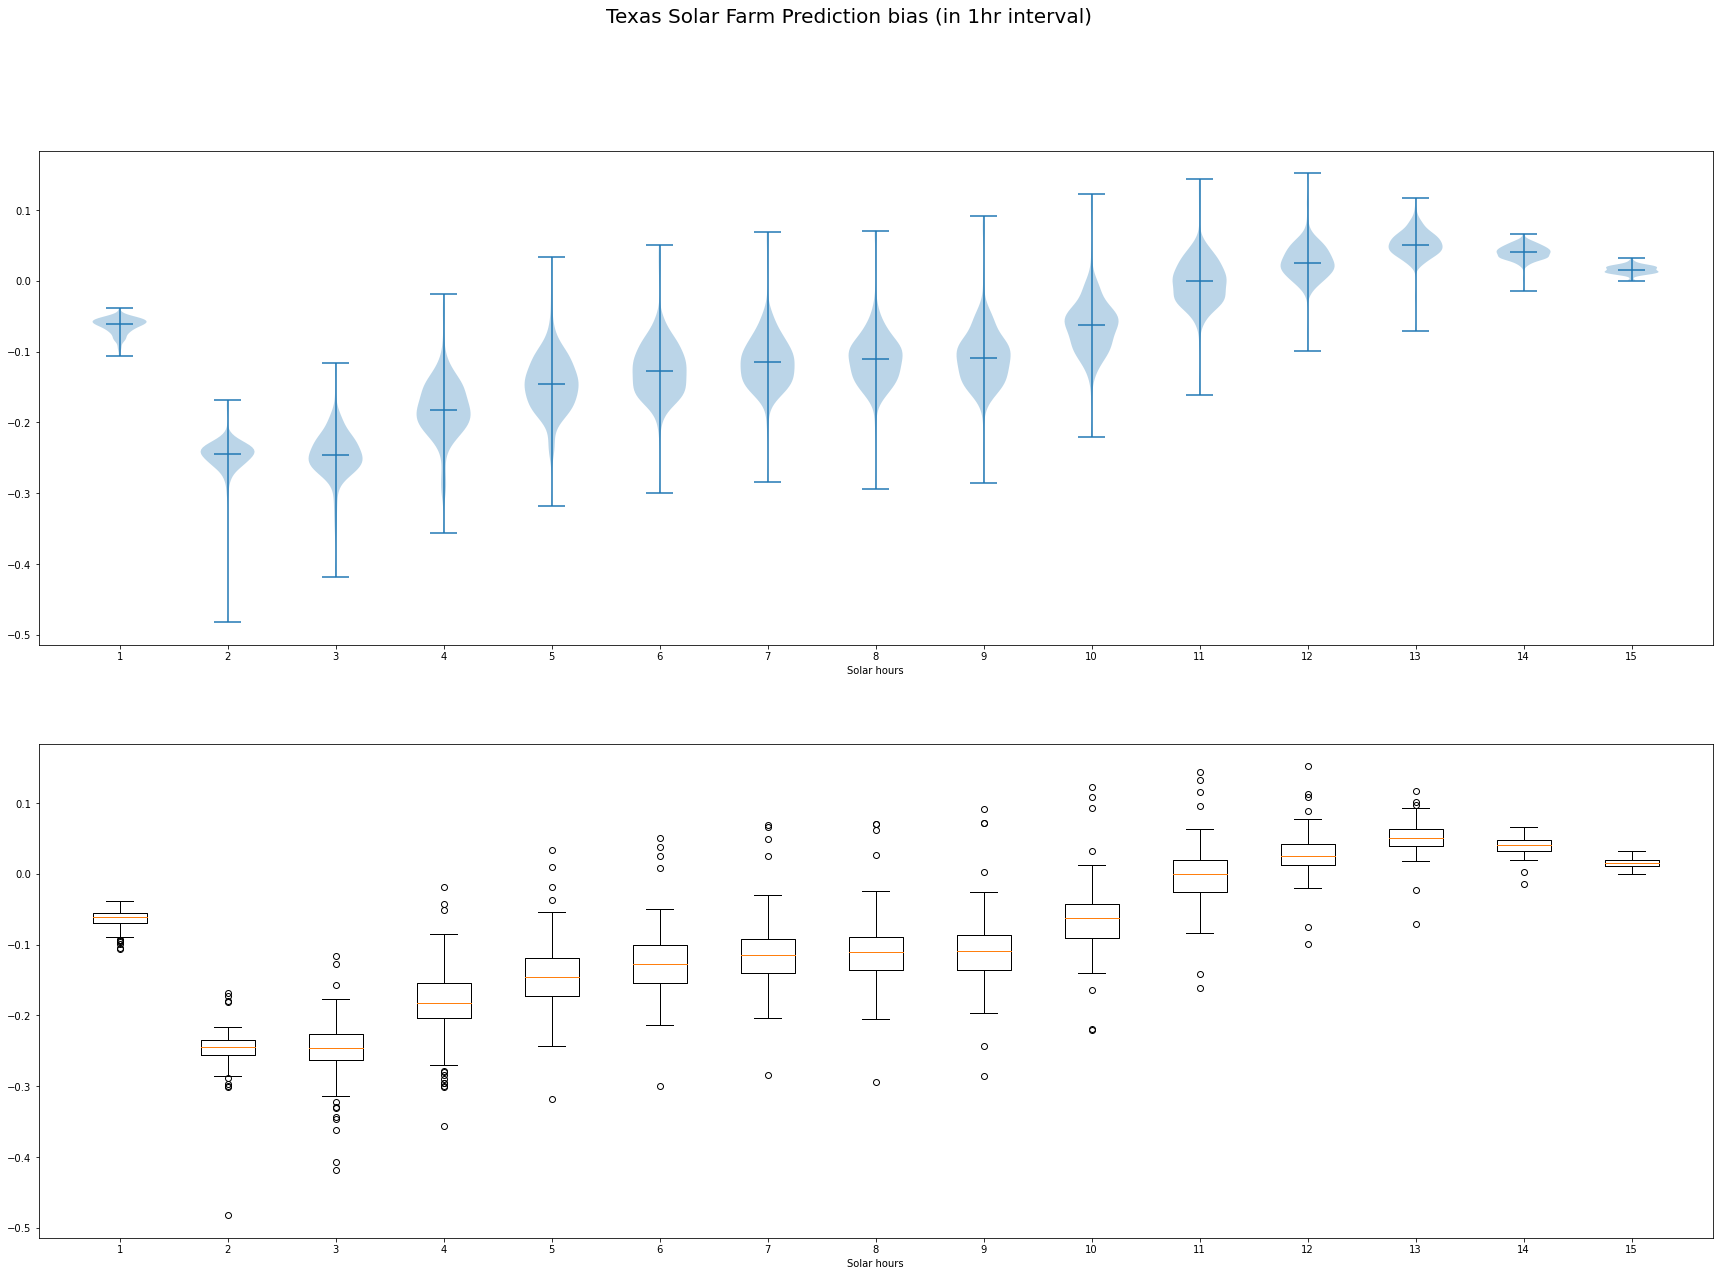

In [221]:
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(30,20))
labels = []

labels = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15"]
axs[0].violinplot(data,showmedians=True)
axs[1].boxplot(data)
set_axis_style(axs[1], labels)
set_axis_style(axs[0], labels)
fig.suptitle("Texas Solar Farm Prediction bias (in 1hr interval)", fontsize=20)
plt.savefig('plots/violin_and_box_bias_1hr.png')
plt.show()

In [222]:
def error_in_interval(a,b):
    solar_actual_6h = solar_actual_2018_5min[(solar_actual_2018_5min['Time'].dt.hour <= b) & (solar_actual_2018_5min['Time'].dt.hour >=a)]
    solar_forcast_6h = solar_day_ahead_forecast_2018[(solar_day_ahead_forecast_2018['horizon_time'].dt.hour <= b) & (solar_day_ahead_forecast_2018['horizon_time'].dt.hour >=a)]
    solar_actual_6h_mean = solar_actual_6h.resample('Y',on= 'Time').mean()
    solar_forcast_6h_mean = solar_forcast_6h.resample('Y',on= 'horizon_time').mean()
    error = solar_actual_6h_mean - solar_forcast_6h_mean
    for (farm, data) in error.iteritems():
        capacity = solar_meta.loc[solar_meta['site_ids']==farm]['AC_capacity_MW']
        error[farm] = error[farm].values[0]/(capacity.values[0])
    error = error.reindex(sorted(error.columns,key=str.lower), axis=1)
    solar_meta['error'] = error.values[0]
error_in_interval(12,24)

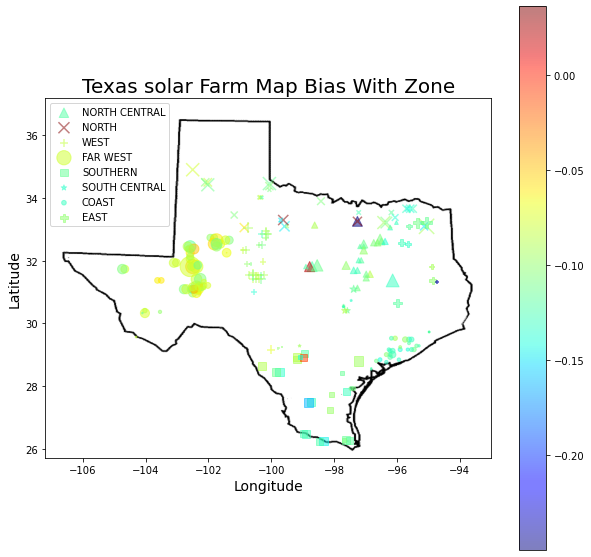

In [223]:
error_in_interval(12,24)
plt.figure(figsize=(10,10))
norm = plt.Normalize(min(solar_meta['error']), max(solar_meta['error']))
for kind in marker_dict:
    plt.scatter(x = solar_meta[solar_meta['Zone']==kind]['longitude'], 
                    y = solar_meta[solar_meta['Zone']==kind]['latitude'], 
                    s = solar_meta[solar_meta['Zone']==kind]['AC_capacity_MW']/3, 
                    c = solar_meta[solar_meta['Zone']==kind]['error'],
                    cmap=plt.get_cmap("jet"),
                    marker = marker_dict[kind],
                    norm = norm,
                    alpha = 0.5)
texas_map = mpimg.imread('map.gif')
plt.colorbar()
plt.legend(marker_dict.keys())
plt.imshow(texas_map, extent=[-107.200, -93.000, 25.732,37.161], alpha=1)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("Texas solar Farm Map Bias With Zone", fontsize=20)
plt.savefig('plots/bias_24hr_with_area.png')
plt.show()

In [224]:
def std_error_in_interval(a,b):
    solar_actual_6h = solar_actual_2018_5min[(solar_actual_2018_5min['Time'].dt.hour <= b) & (solar_actual_2018_5min['Time'].dt.hour >=a)]
    solar_forcast_6h = solar_day_ahead_forecast_2018[(solar_day_ahead_forecast_2018['horizon_time'].dt.hour <= b) & (solar_day_ahead_forecast_2018['horizon_time'].dt.hour >=a)]
    solar_actual_6h_mean = solar_actual_6h.resample('60min',on= 'Time').mean()
    solar_forcast_6h_mean = solar_forcast_6h.resample('60min',on= 'horizon_time').mean()
    diff = solar_actual_6h_mean - solar_forcast_6h_mean
    for (farm, data) in diff.iteritems():
        capacity = solar_meta.loc[solar_meta['site_ids']==farm]['AC_capacity_MW']
        diff[farm] = diff[farm].div(capacity.values[0])
        diff = diff.reindex(sorted(diff.columns,key=str.lower), axis=1)
    solar_meta['std']= np.std(diff).values
    

<Figure size 720x720 with 0 Axes>

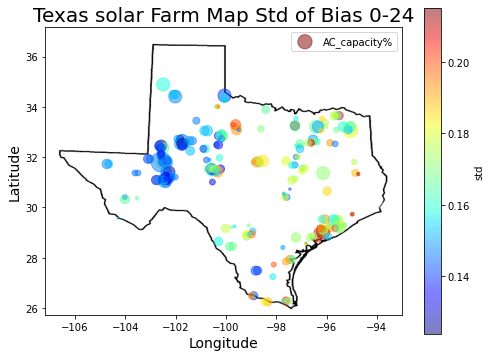

In [225]:
std_error_in_interval(12,24)
plt.figure(figsize=(10,10))
ax = solar_meta.plot(kind="scatter", 
                    x="longitude", 
                    y="latitude", 
                    alpha = 0.5 , 
                    s = solar_meta['AC_capacity_MW']/3,
                    label = "AC_capacity%",
                    c = 'std',
                    cmap=plt.get_cmap("jet"), 
                    colorbar = True, 
                    figsize= (8,6),
                    sharex=False)

texas_map = mpimg.imread('map.gif')
plt.imshow(texas_map, extent=[-107.200, -93.000, 25.732,37.161], alpha=1)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("Texas solar Farm Map Std of Bias 0-24", fontsize=20)
plt.savefig('plots/std_of_bias_24hr.png')
plt.show()

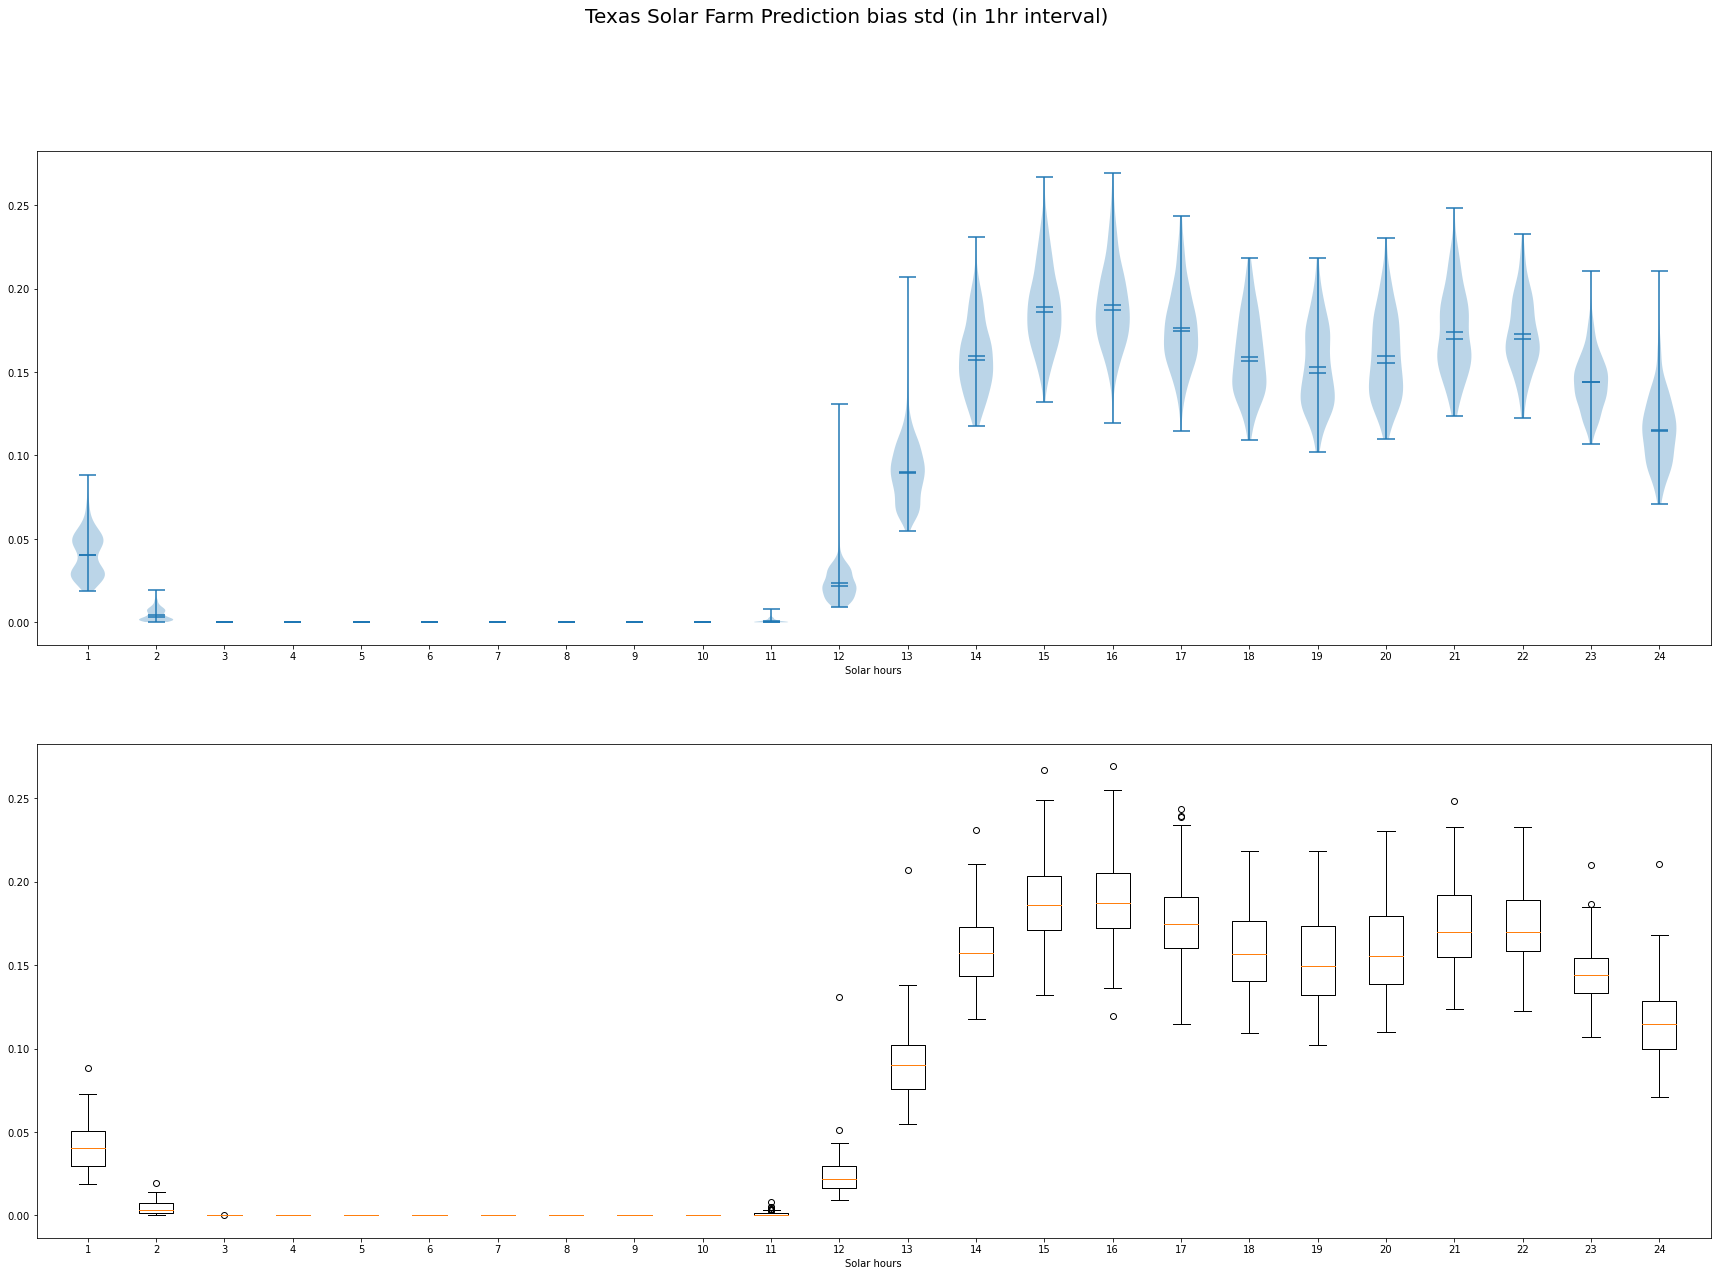

In [226]:
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(30,20))
data = []
labels = []
for i in range(0,24):
    std_error_in_interval(0+1*i,1+1*i)
    data.append(sorted(solar_meta['std']))
    labels += ["{}".format(1+1*i)]
axs[0].violinplot(data,showmeans=True,showmedians=True)
axs[1].boxplot(data)
set_axis_style(axs[1], labels)
set_axis_style(axs[0], labels)
fig.suptitle("Texas Solar Farm Prediction bias std (in 1hr interval)", fontsize=20)
plt.savefig('plots/violin_and_box_std_of_bias_1hr.png')
plt.show()

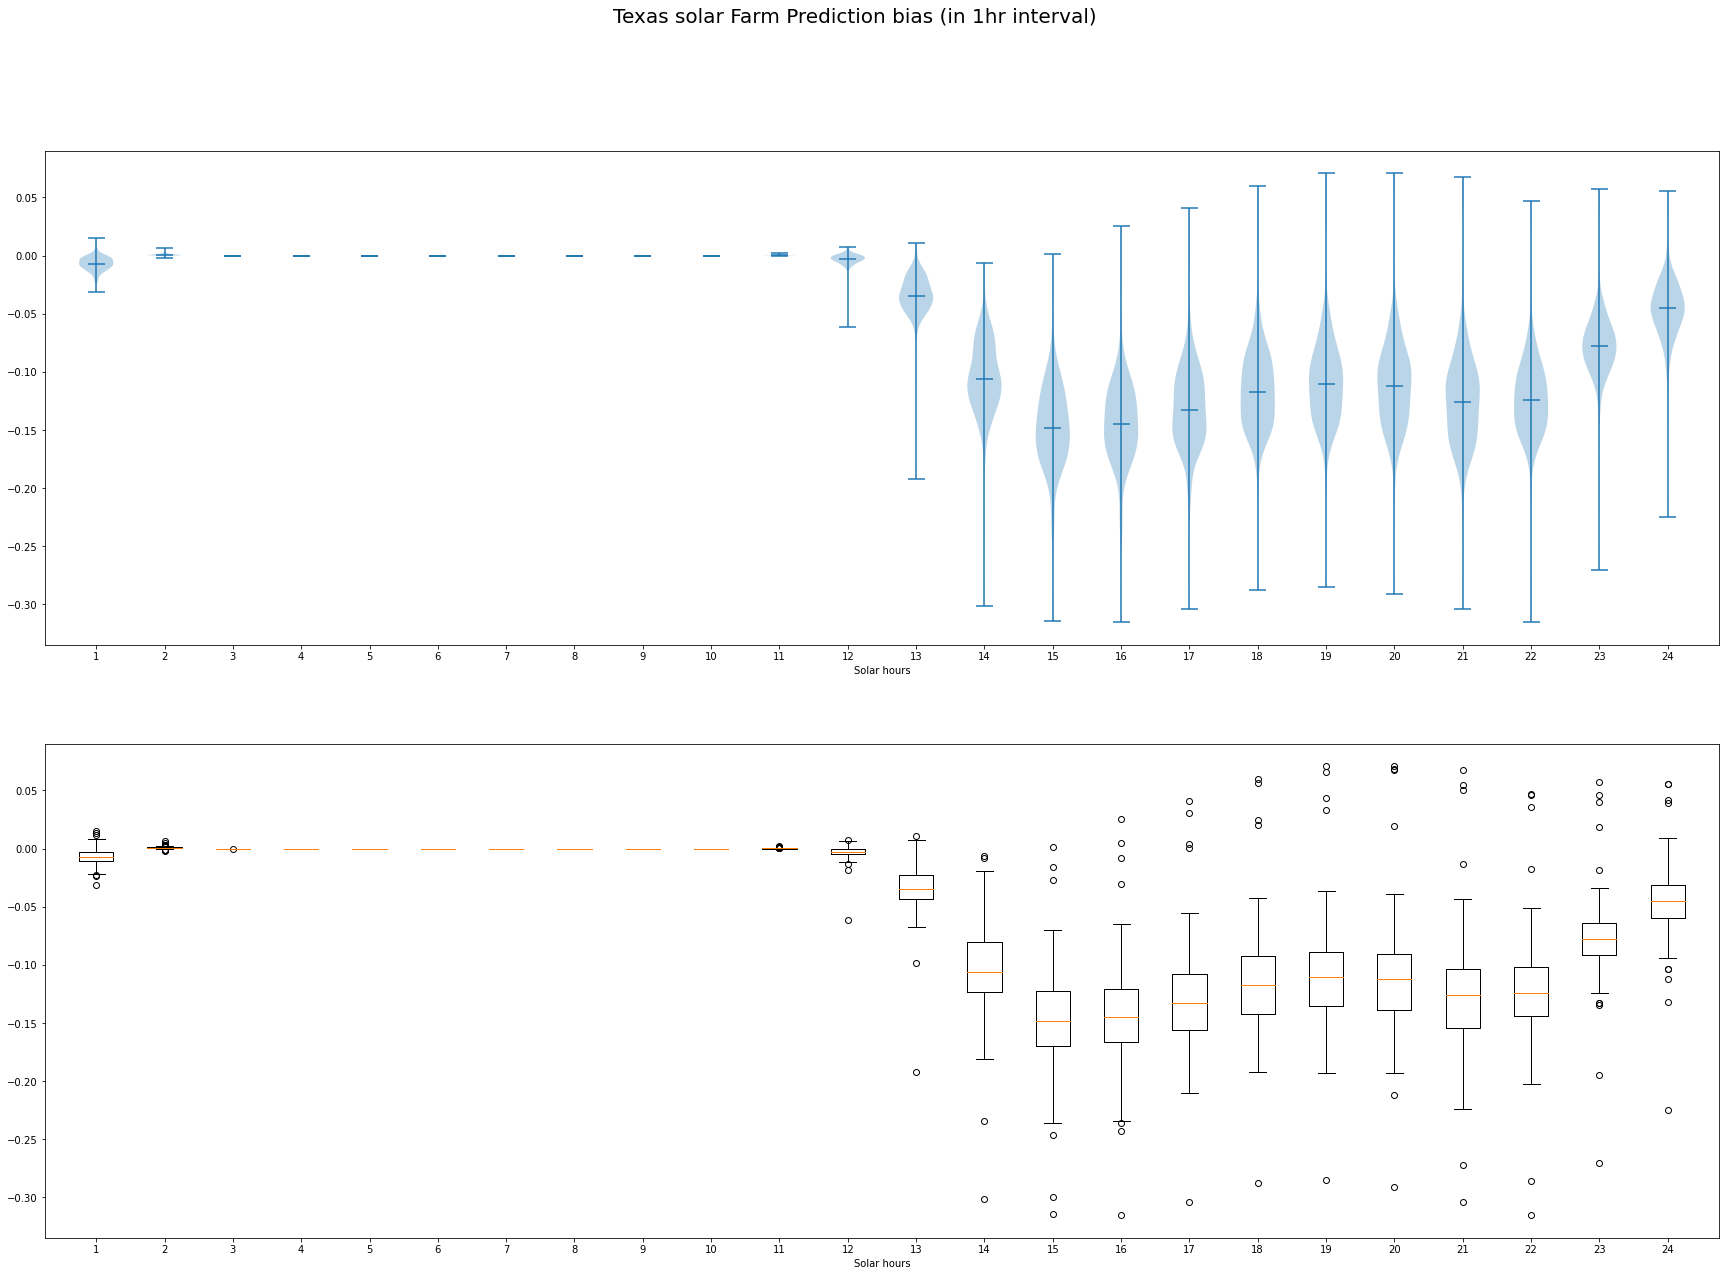

In [227]:
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(30,20))
data = []
labels = []
bias_outliers = []
for i in range(0,24):
    error_in_interval(0+1*i,1+1*i)
    Q1 = solar_meta['error'].quantile(0.25)
    Q3 = solar_meta['error'].quantile(0.75)
    upper = Q3 + (Q3 - Q1) * 2
    lower = Q3 - (Q3 - Q1) * 2
    bias_outliers += solar_meta[(solar_meta["error"] > upper) | (solar_meta["error"] < lower)]['site_ids'].to_list()
    data.append(sorted(solar_meta['error']))
    labels += ["{}".format(1+1*i)]
bias_outliers_table = pd.Series(bias_outliers).value_counts()
bias_outliers_table.to_csv('bias_outliers.csv')
axs[0].violinplot(data,showmedians=True)
axs[1].boxplot(data)
set_axis_style(axs[1], labels)
set_axis_style(axs[0], labels)
fig.suptitle("Texas solar Farm Prediction bias (in 1hr interval)", fontsize=20)
plt.savefig('plots/violin_and_box_bias_1hr.png')
plt.show()

capacity vs unnormalized std

In [244]:
def unormalized_std_error_in_interval(a,b):
    solar_actual_6h = solar_actual_2018_5min[(solar_actual_2018_5min['Time'].dt.hour <= b) & (solar_actual_2018_5min['Time'].dt.hour >=a)]
    solar_forcast_6h = solar_day_ahead_forecast_2018[(solar_day_ahead_forecast_2018['horizon_time'].dt.hour <= b) & (solar_day_ahead_forecast_2018['horizon_time'].dt.hour >=a)]
    solar_actual_6h_mean = solar_actual_6h.resample('60min',on= 'Time').mean()
    solar_forcast_6h_mean = solar_forcast_6h.resample('60min',on= 'horizon_time').mean()
    diff = solar_actual_6h_mean - solar_forcast_6h_mean
    for (farm, data) in diff.iteritems():
        diff = diff.reindex(sorted(diff.columns,key=str.lower), axis=1)
    solar_meta['unnorm_std']= np.std(diff).values
unormalized_std_error_in_interval(12,24)

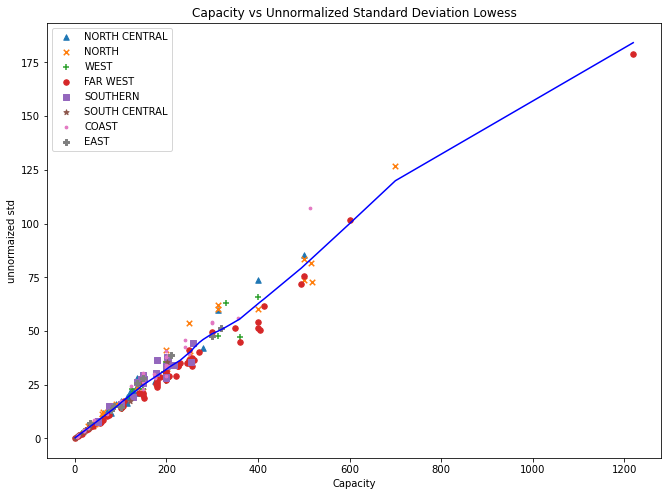

In [246]:

plt.figure(figsize=(11,8))
unormalized_std_error_in_interval(12,24)
error_in_interval(12,24)
norm = plt.Normalize(min(solar_meta['error']), max(solar_meta['error']))
for kind in marker_dict:
    plt.scatter(x = solar_meta[solar_meta['Zone']==kind]['AC_capacity_MW'], 
                y = solar_meta[solar_meta['Zone']==kind]['unnorm_std'],
                s = 30,
                marker = marker_dict[kind]) 
x = solar_meta['AC_capacity_MW']
y = solar_meta['unnorm_std']
filtered = lowess(y, x, frac=0.4, it=0)
plt.plot(filtered[:,0], filtered[:,1], 'b')
plt.xlabel('Capacity')
plt.title('Capacity vs Unnormalized Standard Deviation Lowess')
plt.legend(marker_dict.keys())
plt.ylabel('unnormaized std')
plt.savefig('plots/capacity_vs_unnormstd_lowess.png')
plt.show()

In [230]:
def unnorm_error_in_interval(a,b):
    solar_actual_6h = solar_actual_2018_5min[(solar_actual_2018_5min['Time'].dt.hour <= b) & (solar_actual_2018_5min['Time'].dt.hour >=a)]
    solar_forcast_6h = solar_day_ahead_forecast_2018[(solar_day_ahead_forecast_2018['horizon_time'].dt.hour <= b) & (solar_day_ahead_forecast_2018['horizon_time'].dt.hour >=a)]
    solar_actual_6h_mean = solar_actual_6h.resample('Y',on= 'Time').mean()
    solar_forcast_6h_mean = solar_forcast_6h.resample('Y',on= 'horizon_time').mean()
    error = solar_actual_6h_mean - solar_forcast_6h_mean
    solar_meta['unnorm_error']= error.values[0]

In [231]:
def quantile_error_in_interval(a,b):
    solar_actual = solar_actual_2018_5min[(solar_actual_2018_5min['Time'].dt.hour <= b) & (solar_actual_2018_5min['Time'].dt.hour >=a)]
    solar_actual = solar_actual[solar_actual['Time'].dt.minute == 0]
    solar_forcast = solar_day_ahead_forecast_2018[(solar_day_ahead_forecast_2018['horizon_time'].dt.hour <= b) & (solar_day_ahead_forecast_2018['horizon_time'].dt.hour >=a)]
    solar_actual = solar_actual.reset_index()
    solar_forcast = solar_forcast.reset_index()
    bias = solar_actual.copy(deep=True)
    for col in solar_actual.columns:
        if col != 'Time':
            bias[col] = solar_actual[col] - solar_forcast[col]
    quantile = pd.DataFrame(columns = bias.columns)
    for col in bias:
        if col != 'Time':
            quantile[col] = pd.Series(bias[col].quantile(0.95))
    quantile.drop(['index','Time'],axis=1,inplace=True)
    for (farm, data) in quantile.iteritems():
        capacity = solar_meta.loc[solar_meta['site_ids']==farm]['AC_capacity_MW']
        quantile[farm] = quantile[farm].div(capacity.values[0])
    quantile = quantile.reindex(sorted(quantile.columns,key=str.lower), axis=1)
    solar_meta['95 percentile']= quantile.values[0]
    error_in_interval(a,b)
    solar_meta['quantile'] = - solar_meta['error'] + solar_meta['95 percentile']

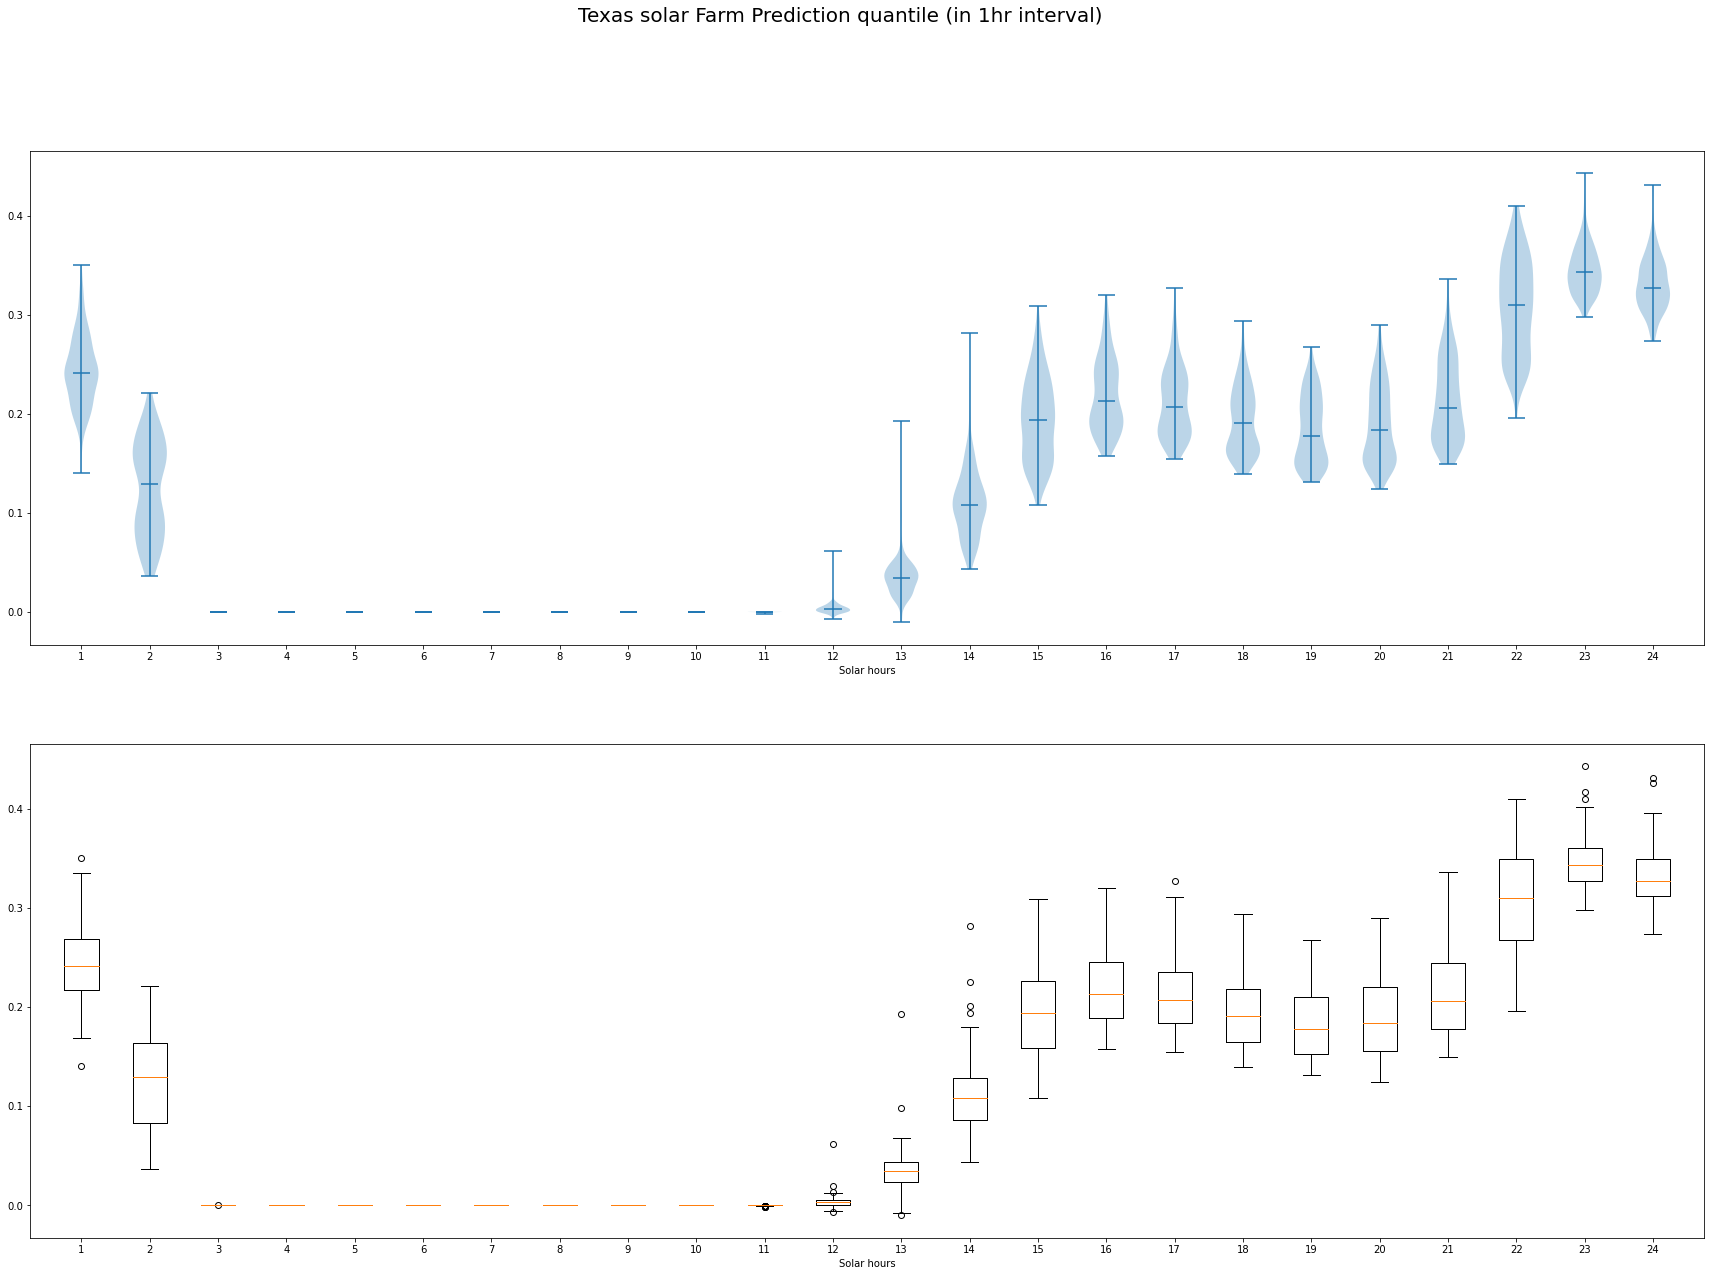

In [232]:
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(30,20))
data = []
labels = []
for i in range(0,24):
    quantile_error_in_interval(0+1*i,1+1*i)
    Q1 = solar_meta['quantile'].quantile(0.25)
    Q3 = solar_meta['quantile'].quantile(0.75)
    data.append(sorted(solar_meta['quantile']))
    labels += ["{}".format(1+1*i)]
axs[0].violinplot(data,showmedians=True)
axs[1].boxplot(data)
set_axis_style(axs[1], labels)
set_axis_style(axs[0], labels)
fig.suptitle("Texas solar Farm Prediction quantile (in 1hr interval)", fontsize=20)
plt.savefig('plots/violin_and_box_quantile_1hr.png')
plt.show()

In [233]:

error_outliers = []
for j in range(0,4):
    for i in range(0,6):
        error_in_interval(6*j+1*i,6*j+1*i+1)
        Q1 = solar_meta['error'].quantile(0.25)
        Q3 = solar_meta['error'].quantile(0.75)
        upper = Q3 + (Q3 - Q1) * 2
        lower = Q3 - (Q3 - Q1) * 2
        error_minus_mean_outliers = solar_meta[(solar_meta["error"] > upper) | (solar_meta["error"] < lower)]['site_ids'].to_list()
        print("hour {}".format(6*j+1*i))
        print(solar_meta[(solar_meta["error"] > upper) | (solar_meta["error"] < lower)])
        error_outliers += error_minus_mean_outliers
error_outliers = pd.Series(error_outliers).value_counts()
error_outliers.to_csv('bias_outliers.csv')

hour 0
                  site_ids  AC_capacity_MW  latitude  longitude  elevation  \
52            Eunice Solar          403.80     32.45    -102.58     968.56   
61              Frye Solar          500.00     34.41    -102.02    1124.48   
86                IP Titan          272.00     31.73    -104.74    1587.50   
115         Nazareth Solar          201.00     34.49    -102.10    1158.60   
117            Noble Solar          300.00     33.25     -97.26     220.16   
134           Prickly Pear          102.50     31.01    -100.54     693.88   
137                Quantum          313.20     33.29     -99.62     458.76   
140                 Radian          313.20     31.81     -98.78     497.52   
145  RE Maplewood 2a Solar          222.00     31.09    -102.50     724.30   
187               solar509           33.00     31.33     -94.74      89.25   
204       Taygete II Solar          256.25     31.09    -102.78     771.80   

     timezone  proposed           Zone    ISO     error 

In [234]:

std_outliers = []
for j in range(0,4):
    for i in range(0,6):
        std_error_in_interval(6*j+1*i,6*j+1*i+1)
        Q1 = solar_meta['std'].quantile(0.25)
        Q3 = solar_meta['std'].quantile(0.75)
        upper = Q3 + (Q3 - Q1) * 2
        lower = Q3 - (Q3 - Q1) * 2
        std_minus_mean_outliers = solar_meta[(solar_meta["std"] > upper) | (solar_meta["std"] < lower)]['site_ids'].to_list()
        print("hour {}".format(6*j+1*i))
        print(solar_meta[(solar_meta["std"] > upper) | (solar_meta["std"] < lower)])
        std_outliers += std_minus_mean_outliers
std_outliers = pd.Series(std_outliers).value_counts()
std_outliers.to_csv('std_outliers.csv')

hour 0
Empty DataFrame
Columns: [site_ids, AC_capacity_MW, latitude, longitude, elevation, timezone, proposed, Zone, ISO, error, std, unnorm_std, 95 percentile, quantile]
Index: []
hour 1
    site_ids  AC_capacity_MW  latitude  longitude  elevation  timezone  \
137  Quantum           313.2     33.29     -99.62     458.76        -6   

     proposed   Zone    ISO     error       std  unnorm_std  95 percentile  \
137  Proposed  NORTH  ERCOT  0.055788  0.019448   44.641212       0.424744   

     quantile  
137  0.368957  
hour 2
    site_ids  AC_capacity_MW  latitude  longitude  elevation  timezone  \
86  IP Titan           272.0     31.73    -104.74     1587.5        -6   

    proposed      Zone    ISO     error       std  unnorm_std  95 percentile  \
86  Proposed  FAR WEST  ERCOT -0.093897  0.000008   22.580596       0.282936   

    quantile  
86  0.376833  
hour 3
Empty DataFrame
Columns: [site_ids, AC_capacity_MW, latitude, longitude, elevation, timezone, proposed, Zone, ISO, error

In [235]:
quantile_outliers = []
for j in range(0,4):
    for i in range(0,6):
        quantile_error_in_interval(6*j+1*i,6*j+1*i+1)
        Q1 = solar_meta['quantile'].quantile(0.25)
        Q3 = solar_meta['quantile'].quantile(0.75)
        upper = Q3 + (Q3 - Q1) * 2
        lower = Q3 - (Q3 - Q1) * 2
        quantile_minus_mean_outliers = solar_meta[(solar_meta["quantile"] > upper) | (solar_meta["quantile"] < lower)]['site_ids'].to_list()
        quantile_outliers += quantile_minus_mean_outliers
quantile_outliers = pd.Series(quantile_outliers).value_counts()
quantile_outliers.to_csv('quantile_outliers.csv')
quantile_outliers

solar509                  5
Noble Solar               4
Adamstown Solar           3
Quantum                   3
Radian                    2
solar436                  1
RE Maplewood 2b Solar     1
Prospero Solar            1
Wang Solar                1
Wagyu Solar               1
Texana Solar              1
Sun Valley                1
Solemio                   1
solar530                  1
solar438                  1
solar437                  1
solar435                  1
IP Titan                  1
solar434                  1
Samson Solar              1
Ramsey Solar              1
Long Point Solar          1
Lily Solar                1
Fort Bend Solar           1
Delilah Solar 1           1
Danish Fields II          1
Danciger Solar            1
Cutlass Solar             1
Cottonwood Bayou          1
Angelina Solar            1
solar433                  1
dtype: int64

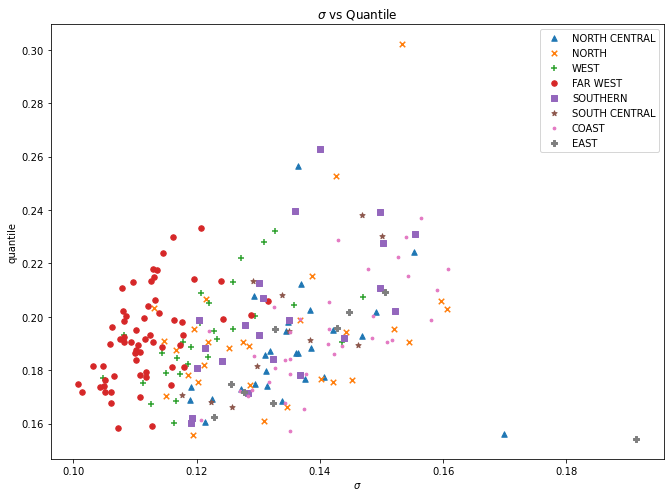

In [248]:

plt.figure(figsize=(11,8))
quantile_error_in_interval(0,24)
std_error_in_interval(0,24)
for kind in marker_dict:
    plt.scatter(x = solar_meta[solar_meta['Zone']==kind]['std'], 
                y = solar_meta[solar_meta['Zone']==kind]['quantile'],
                s = 30,
                marker = marker_dict[kind]) 

plt.xlabel('$\sigma$')
plt.title('$\sigma$ vs Quantile')
plt.legend(marker_dict.keys())
plt.ylabel('quantile')
plt.savefig('plots/sigma_vs_quantile.png')
plt.show()
